## Creating a classifier that can distinguish between 3s and 7s

Skills covered in these notes:
- PIL and working with tensors

## Creating Tensors from MNIST Data

In [1]:
import fastbook
from fastai.vision.all import *
from fastbook import *

matplotlib.rc('image', cmap='Greys')

In [2]:
path = untar_data(URLs.MNIST_SAMPLE)

In [3]:
Path.BASE_PATH = path

Ideas for recognising 3s and 7s
1. Recognising linear and curved strokes and how they mesh together

Identifying a basline - comparing to the average 3 and the average 7
- find a simple, easy to implement model to see if your approach is any good

In [4]:
path.ls()

(#3) [Path('valid'),Path('train'),Path('labels.csv')]

In [5]:
(path/'train').ls()

(#2) [Path('train/3'),Path('train/7')]

In [6]:
threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()

In [7]:
im3_path = threes[1]
im3 = Image.open(im3_path)
im3

In [8]:
array(im3)[4:10,4:10]

array([[  0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,  29],
       [  0,   0,   0,  48, 166, 224],
       [  0,  93, 244, 249, 253, 187],
       [  0, 107, 253, 253, 230,  48],
       [  0,   3,  20,  20,  15,   0]], dtype=uint8)

In [9]:
tensor(im3)[4:10,4:10]

tensor([[  0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,  29],
        [  0,   0,   0,  48, 166, 224],
        [  0,  93, 244, 249, 253, 187],
        [  0, 107, 253, 253, 230,  48],
        [  0,   3,  20,  20,  15,   0]], dtype=torch.uint8)

In [10]:
im3_t = tensor(im3)
df = pd.DataFrame(im3_t[4:15,4:22])
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,29,150,195,254,255,254,176,193,150,96,0,0,0
2,0,0,0,48,166,224,253,253,234,196,253,253,253,253,233,0,0,0
3,0,93,244,249,253,187,46,10,8,4,10,194,253,253,233,0,0,0
4,0,107,253,253,230,48,0,0,0,0,0,192,253,253,156,0,0,0
5,0,3,20,20,15,0,0,0,0,0,43,224,253,245,74,0,0,0
6,0,0,0,0,0,0,0,0,0,0,249,253,245,126,0,0,0,0
7,0,0,0,0,0,0,0,14,101,223,253,248,124,0,0,0,0,0
8,0,0,0,0,0,11,166,239,253,253,253,187,30,0,0,0,0,0
9,0,0,0,0,0,16,248,250,253,253,253,253,232,213,111,2,0,0



A tensor's length is its rank:
len(stacked_threes.shape) = 3 = tensor.ndim
shape = size of each axis of a tensor

Calculate the mean of all images by taking the mean along dimension 0 of a stacked, rank 3 tensor.
- Stacking over all the images 

## Computing Similarity

Idea is that we find the average pixel value for each of the 3s and the 7s, and then classify which of the two averages the image is closest to.

In [11]:
seven_tensors = [tensor(Image.open(o)) for o in sevens]
#Using python list comprehension
three_tensors = [tensor(Image.open(o)) for o in threes]
len(three_tensors),len(seven_tensors)

(6131, 6265)

In [28]:
three_tensors[1].shape
#We have 6131 entries of a 28x28 in an array

torch.Size([28, 28])

In [30]:
stacked_sevens = torch.stack(seven_tensors).float()/255
#To typecast in PyTorch, type name of type as method
stacked_sevens.shape

torch.Size([6265, 28, 28])

<Axes: >

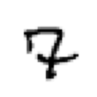

In [13]:
show_image(seven_tensors[2])

In [14]:
stacked_threes = torch.stack(three_tensors).float()/255
stacked_threes.shape

torch.Size([6131, 28, 28])

This has a rank of 3, consisting of 6131 , 28x28 pixels 

*Rank* is the number of axes or dimensions in the tensor. *shape* is the size of each axis in a tensor. Rank can be found by doing ```len(tensor.shape)``` or ```tensor.ndim```

In [31]:
mean3.ndim

2

<Axes: >

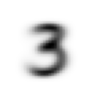

In [32]:
mean3 = stacked_threes.mean(0)
# this computes the mean along the 0th dimension of the tensor
show_image(mean3)

<Axes: >

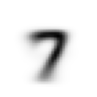

In [16]:
mean7 = stacked_sevens.mean(0)
show_image(mean7)

How to measure how a particlular image is different 
- compute the MSE values of every pixel?


**Mean absolute difference or L1 norm**
is the mean of the absolute value of differences
(a-b).abs().mean()
**MSE**
- mean of the squared error, 
- will punish larger differences more


**.backward**
- the same as calculate_grad

## Using gradient calcs

In [17]:
def f(x): return x**2

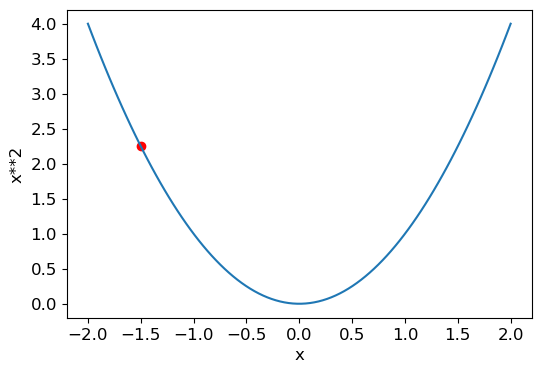

In [18]:
plot_function(f, 'x', 'x**2')
plt.scatter(-1.5, f(-1.5), color='red')

In [19]:
xt = tensor(3.).requires_grad_()

In [20]:
yt = f(xt)
yt

tensor(9., grad_fn=<PowBackward0>)

In [21]:
yt.backward()

In [22]:
xt.grad 

tensor(6.)

In [23]:
xt = tensor(3.,4.,10.).requires_grad_()

In [24]:
def f(x): return (x**2).sum()

yt = f(xt)
yt

tensor(125., grad_fn=<SumBackward0>)

In [25]:
yt.backward()
xt.grad

tensor([ 6.,  8., 20.])

Small notes about tensors:
- Tensors will automatically change type when needed
- functionally identical to numpy arrays.

## Computing metrics using broadcasting

In [39]:
valid_3_t = torch.stack([tensor(Image.open(o)) for o in (path/'valid'/'3').ls()])
valid_3_t = valid_3_t.float()/255
valid_3_t.shape

torch.Size([1010, 28, 28])

In [42]:
valid_7_t = torch.stack([tensor(Image.open(o)) for o in (path/'valid'/'7').ls()])
valid_7_t = valid_7_t.float()/255
valid_7_t.shape

torch.Size([1028, 28, 28])

Now begins the magic of broadcasting.
PyTorch treats the ideal image tensor, as 1010 copies of the same tensor and allows us to apply the mse function on it. We now get a rank 1 tensor of length 1010.

In [52]:
def new_mae(a,b): return (a-b).abs().mean((-1,-2))
#mean((-1,-2)) indicates that the mean should be taken over the last two axes of the tensor

In [49]:
new_mae(valid_3_t[1], mean3)

tensor(0.1114)

In [50]:
new_mae(valid_3_t, mean3)

tensor([0.1288, 0.1114, 0.1183,  ..., 0.1406, 0.1047, 0.1095])

In [51]:
new_mae(valid_3_t, mean3).shape

torch.Size([1010])

In [53]:
def is_3(x): return new_mae(x, mean3) < new_mae(x, mean7)

In [55]:
is_3(valid_3_t)

tensor([ True,  True,  True,  ..., False,  True,  True])

In [59]:
#Checking accuracy for 3s
acc_3 = is_3(valid_3_t).float().mean()
acc_3

tensor(0.9168)

## Stochastic Gradient Descent (SGD)

Main idea behind how it works:

We want a function:

```python
def pr_eight(x,w): return (x*w).sum()
```

Where:
- x is the image, represented as a vector
- w are the weights, and correspond to how likely a pixel is to be activated in 8

Our plan:
1. Initialise the weights
2. For each image, use the weights to predict whether its a 3 or 7
3. For each prediction, calculate the loss
4. calculate the gradients for the weights
5. *step* the weights
6. return to step 2 and repeat the process
7. iterate until you want to stop the training process

NameError: name 'gv' is not defined